In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime, timedelta, time
import matplotlib.style as style
import settings
style.use(style='fivethirtyeight')
%matplotlib inline

## Introduction
I have requested my listening history data from Spotify and in addition to this data have retrieved additional pieces of information on each of those tracks from the Spotify API utilizing the Python package [spotipy](https://spotipy.readthedocs.io/en/2.18.0/#). I am interested in investigating who I am as a Spotify user, when do I listen to songs, when do I listen to podcasts, how does that balance change over time? How do the songs I listen to change over time?<br> 

The pieces of information collected for analysis are:<br><br>

<b>Provided by Spotify in my data request</b><br>
<b>endTime</b> - The date and time at which listening to the track ended. <br>
<b>artistName</b> - The name of the artist of the track (only the releasing artist, not features or collaborations). <br>
<b>trackName</b> - The name of the track. Note that this includes songs and pocast episodes. <br>
<b>msPlayed</b> - The number of milliseconds of the track that were played. <br>

<b>Retrieved via the Spotify API</b><br>
<b>type</b> - Whether the track is a song or podcast. <br>
<b>artist_genres</b> - All genres listed in the artist's Spotify profile (not song specific).<br>
<b>artist_popularity</b> - A number between 0 and 100 (100 is the most popular) quanitifing an artists popularity. It is calculated by the number of plays an artist has accrued and how recent they are. <br>
<b>track_popularity</b> - Similar to artist popularity this is a number between 0 and 100 quanitfying track popularity and is calculated on a similar manner, but specific to an individual song. <br>

<b>Audio Features From Spotify (also from the API). For a more detailed desription of each see the data collection notebook</b><br>
<b>acousticness</b> - "A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic."<br>
<b>danceability</b> - How suitable a track is for dancing on a scale from 0-1. <br>
<b>duration_ms</b> - The length of a song (ms). <br>
<b>energy</b> - A measure of a songs energy on a scale from 0 - 1. According to Spotify: "Typically, energetic tracks feel fast, loud, and noisy." <br>
<b>id</b> - "The Spotify ID for the track." <br>
<b>instrumentalness</b> - Attemping to measure whether a song contains vocals. A score of 1 would contain no vocals. <br>
<b>liveness</b> - A measure of the likliehood that the track was performed live on a scale from 0-1. <br>
<b>loudness</b> - "The overall loudness of a track in decibels (dB). Averaged over the track and useful for comparing relative loudness of tracks rather than in a vacuum. Values typical range between -60 and 0 db." <br>
<b>mode</b> - Mode indicates whether a track is in a major or minor scale. Major is represented by 1 and minor is 0. <br>
<b>speechiness</b> - How much of the track is made of spoken-word like content. Greater than .66 is likely music and less than .33 is likely spoken word such as an audio book. <br>
<b>tempo</b> - "The estimated tempo in beats per minute (BPM). Tempo is the speed or pace of a given piece derived from the average beat duration. <br>
<b>valence</b> - An estimate from 0 to 1 of the musical positiveness in the track. Higher valence equates to a more positive sounding track.<br><br>
<b>Attributes to be used</b><br>
Of the eight attributes on a 0 - 1 scale we will not be looking at speechiness and liveness as we have decided these convey less information about the music itself and we will look at acousticness, danceability, energy, instrumentalness, mode, and valence to represent the type and style of music being listened to. 


## Read, Clean, and Prep the Data
We will start by loading in the csv file with all of the track information for the unique songs in the listening history along with the csv of the full listening history. We'll be merging these dataframes, so a couple of column titles need to be updated to match, and we'll capitalize the attributes.

In [2]:
#Read in csv with all info for all unique tracks in my listening history
df = pd.read_csv('listening_history_unique_songs.csv')
#Read in csv to dataframe full listening history
df_full_history = pd.read_csv('full_streaming_history.csv')

print(df.columns)
print(df_full_history.columns)

Index(['Unnamed: 0', 'name', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'artist_name', 'artist_genres',
       'artist_popularity', 'track_popularity'],
      dtype='object')
Index(['Unnamed: 0', 'endTime', 'artistName', 'trackName', 'msPlayed'], dtype='object')


In [3]:
#Update column titles to match across dataframes where appropriate
name_mapper = {'name':'trackName'}
df.rename(columns=name_mapper, inplace=True)
artist_mapper = {'artist_name':'artistName'}
df.rename(columns=artist_mapper, inplace=True)
type_mapper = {'type':'Type'}
df.rename(columns=type_mapper, inplace=True)
#Capitalize attribute columns
att_mapper = {'danceability':'Danceability', 'energy':'Energy', 'key':'Key', 'loudness':'Loudness',
       'mode':'Mode', 'speechiness':'Speechiness', 'acousticness':'Acousticness',
        'instrumentalness':'Instrumentalness', 'liveness':'Liveness', 'valence':'Valence', 'tempo':'Tempo'}
df.rename(columns=att_mapper, inplace=True)
print(df.columns)
print(df_full_history.columns)

Index(['Unnamed: 0', 'trackName', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'artistName', 'artist_genres',
       'artist_popularity', 'track_popularity'],
      dtype='object')
Index(['Unnamed: 0', 'endTime', 'artistName', 'trackName', 'msPlayed'], dtype='object')


## Merge Full History with Unique Track df 
The dataframes are merged into a full dataframe that contains the full listening history with the track information from the unique track dataframe added to each track. After creating the merged dataframe we convert the endTime to a datetime object and remove some unnecessary columns. 

In [4]:
#Merge dataframes on trackName and artistName
df_full_hist_atr = df_full_history.merge(right=df, how='left', on=['trackName','artistName'])
df_full_hist_atr.head()

,Unnamed: 0_x,endTime,artistName,trackName,msPlayed,Unnamed: 0_y,Danceability,Energy,Key,Loudness,...,Type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist_genres,artist_popularity,track_popularity
0,0,2020-05-01 02:01,SAINt JHN,Roses - Imanbek Remix,176218,0.0,0.769,0.719,8.0,-5.472,...,track,0zLCBJZSiELJf02ucPP9wb,spotify:track:0zLCBJZSiELJf02ucPP9wb,https://api.spotify.com/v1/tracks/0zLCBJZSiELJ...,https://api.spotify.com/v1/audio-analysis/0zLC...,176867.0,4.0,"['melodic rap', 'rap', 'slap house']",80.0,74.0
1,1,2020-05-01 02:04,Ehrling,In My Soul,1909,1.0,0.674,0.801,0.0,-7.340,...,track,443pVyfo5UEloBAYa91tXf,spotify:track:443pVyfo5UEloBAYa91tXf,https://api.spotify.com/v1/tracks/443pVyfo5UEl...,https://api.spotify.com/v1/audio-analysis/443p...,195484.0,4.0,['tropical house'],65.0,40.0
2,2,2020-05-01 02:04,The Middle Coast,Me Tonight,177426,2.0,0.661,0.655,0.0,-7.499,...,track,2uFCDWBNbw2vKx0Iux69zD,spotify:track:2uFCDWBNbw2vKx0Iux69zD,https://api.spotify.com/v1/tracks/2uFCDWBNbw2v...,https://api.spotify.com/v1/audio-analysis/2uFC...,177427.0,4.0,['manitoba indie'],31.0,44.0
3,3,2020-05-01 02:07,Kygo,Like It Is,183067,3.0,0.794,0.728,1.0,-6.759,...,track,3frUvGrmGcay91lvFbOgsN,spotify:track:3frUvGrmGcay91lvFbOgsN,https://api.spotify.com/v1/tracks/3frUvGrmGcay...,https://api.spotify.com/v1/audio-analysis/3frU...,183067.0,4.0,"['edm', 'pop', 'pop dance', 'tropical house']",87.0,71.0
4,4,2020-05-01 02:10,Tep No,"Breathe, Be Happy - French Braids Remix",171250,4.0,0.828,0.729,3.0,-5.198,...,track,2mCs9yDHgcwbYwGSaT7D7a,spotify:track:2mCs9yDHgcwbYwGSaT7D7a,https://api.spotify.com/v1/tracks/2mCs9yDHgcwb...,https://api.spotify.com/v1/audio-analysis/2mCs...,171250.0,4.0,"['deep tropical house', 'indie poptimism', 'ne...",62.0,36.0


In [5]:
#create datetime object from the endTime and remove the previous endTime column
df_full_hist_atr['endTime_dt'] = pd.to_datetime(df_full_hist_atr['endTime'])
df_full_hist_atr.drop('endTime', inplace=True, axis=1)

#drop unnecessary columns
df_full_hist_atr.drop('Unnamed: 0_x', inplace=True, axis=1)
df_full_hist_atr.drop('uri', inplace=True, axis=1)
df_full_hist_atr.drop('track_href', inplace=True, axis=1)
df_full_hist_atr.drop('analysis_url', inplace=True, axis=1)
df_full_hist_atr.drop('Unnamed: 0_y', inplace=True, axis=1)

df_full_hist_atr.head()

,artistName,trackName,msPlayed,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,Valence,Tempo,Type,id,duration_ms,time_signature,artist_genres,artist_popularity,track_popularity,endTime_dt
0,SAINt JHN,Roses - Imanbek Remix,176218,0.769,0.719,8.0,-5.472,1.0,0.0474,0.0143,...,0.863,121.955,track,0zLCBJZSiELJf02ucPP9wb,176867.0,4.0,"['melodic rap', 'rap', 'slap house']",80.0,74.0,2020-05-01 02:01:00
1,Ehrling,In My Soul,1909,0.674,0.801,0.0,-7.340,1.0,0.0399,0.1760,...,0.752,124.104,track,443pVyfo5UEloBAYa91tXf,195484.0,4.0,['tropical house'],65.0,40.0,2020-05-01 02:04:00
2,The Middle Coast,Me Tonight,177426,0.661,0.655,0.0,-7.499,1.0,0.0260,0.0454,...,0.601,113.066,track,2uFCDWBNbw2vKx0Iux69zD,177427.0,4.0,['manitoba indie'],31.0,44.0,2020-05-01 02:04:00
3,Kygo,Like It Is,183067,0.794,0.728,1.0,-6.759,1.0,0.1140,0.1210,...,0.360,105.024,track,3frUvGrmGcay91lvFbOgsN,183067.0,4.0,"['edm', 'pop', 'pop dance', 'tropical house']",87.0,71.0,2020-05-01 02:07:00
4,Tep No,"Breathe, Be Happy - French Braids Remix",171250,0.828,0.729,3.0,-5.198,1.0,0.1300,0.0395,...,0.658,107.994,track,2mCs9yDHgcwbYwGSaT7D7a,171250.0,4.0,"['deep tropical house', 'indie poptimism', 'ne...",62.0,36.0,2020-05-01 02:10:00


## Updating Timezone
From May 2020 - through August 30 2020 I was in the UTC-8 timezone and for the rest of the year this dataset covers I was in UTC +0, so we'll adjust the time of the datetime object accordingly. 

In [6]:
    '''Update the endTime column to your timezone. Settings are in settings.py to be configured. 
    Code allows for a beginning and end of time to change.'''; 
if settings.change_timezone:
        df_full_hist_atr.loc[(df_full_hist_atr.endTime_dt > settings.timezone_change_start)
                             &(df_full_hist_atr.endTime_dt < settings.timezone_change_end),
                              'endTime_dt'] = df_full_hist_atr.endTime_dt + timedelta(hours=settings.hours_different)
    
df_full_hist_atr.head(50)

,artistName,trackName,msPlayed,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,Valence,Tempo,Type,id,duration_ms,time_signature,artist_genres,artist_popularity,track_popularity,endTime_dt
0,SAINt JHN,Roses - Imanbek Remix,176218,0.769,0.719,8.0,-5.472,1.0,0.0474,0.014300,...,0.8630,121.955,track,0zLCBJZSiELJf02ucPP9wb,176867.0,4.0,"['melodic rap', 'rap', 'slap house']",80.0,74.0,2020-04-30 18:01:00
1,Ehrling,In My Soul,1909,0.674,0.801,0.0,-7.340,1.0,0.0399,0.176000,...,0.7520,124.104,track,443pVyfo5UEloBAYa91tXf,195484.0,4.0,['tropical house'],65.0,40.0,2020-04-30 18:04:00
2,The Middle Coast,Me Tonight,177426,0.661,0.655,0.0,-7.499,1.0,0.0260,0.045400,...,0.6010,113.066,track,2uFCDWBNbw2vKx0Iux69zD,177427.0,4.0,['manitoba indie'],31.0,44.0,2020-04-30 18:04:00
3,Kygo,Like It Is,183067,0.794,0.728,1.0,-6.759,1.0,0.1140,0.121000,...,0.3600,105.024,track,3frUvGrmGcay91lvFbOgsN,183067.0,4.0,"['edm', 'pop', 'pop dance', 'tropical house']",87.0,71.0,2020-04-30 18:07:00
4,Tep No,"Breathe, Be Happy - French Braids Remix",171250,0.828,0.729,3.0,-5.198,1.0,0.1300,0.039500,...,0.6580,107.994,track,2mCs9yDHgcwbYwGSaT7D7a,171250.0,4.0,"['deep tropical house', 'indie poptimism', 'ne...",62.0,36.0,2020-04-30 18:10:00
5,Alesso,One Last Time,240383,0.566,0.909,8.0,-7.281,0.0,0.0540,0.004000,...,0.3820,127.037,track,17kleFbwU5STT8AiR1EXOT,240384.0,4.0,"['dance pop', 'edm', 'electro house', 'pop', '...",80.0,55.0,2020-04-30 18:14:00
6,MEDUZA,Born To Love (feat. SHELLS),162295,0.722,0.856,1.0,-6.392,0.0,0.0338,0.030500,...,0.8270,121.990,track,7cX5H82DTZ5iHRLbewBEBd,162295.0,4.0,"['dance pop', 'edm', 'pop dance', 'pop house',...",83.0,65.0,2020-04-30 18:16:00
7,Field Report,Home (Leave the Lights On),221146,0.711,0.625,2.0,-7.605,1.0,0.0257,0.216000,...,0.4620,101.990,track,1nplIOuXXSjLSZdxYTqnZe,221147.0,4.0,"['milwaukee indie', 'stomp and flutter']",26.0,28.0,2020-04-30 18:20:00
8,Ripe,Little Less Polite,262408,0.778,0.736,9.0,-6.295,0.0,0.0593,0.008400,...,0.5370,119.992,track,74qveXO6QQiYVqBx9J2nrZ,262409.0,4.0,['boston indie'],51.0,32.0,2020-04-30 18:24:00
9,JONES,Hoops - Acoustic,206062,0.739,0.198,11.0,-6.789,0.0,0.0326,0.883000,...,0.1920,119.954,track,4os68qINs29EvlHxXmsjVG,206062.0,4.0,['uk contemporary r&b'],51.0,40.0,2020-04-30 18:28:00


In [7]:
#Inspect the dataframe
df_full_hist_atr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13035 entries, 0 to 13034
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   artistName         13035 non-null  object        
 1   trackName          13035 non-null  object        
 2   msPlayed           13035 non-null  int64         
 3   Danceability       11740 non-null  float64       
 4   Energy             11740 non-null  float64       
 5   Key                11740 non-null  float64       
 6   Loudness           11740 non-null  float64       
 7   Mode               11740 non-null  float64       
 8   Speechiness        11740 non-null  float64       
 9   Acousticness       11740 non-null  float64       
 10  Instrumentalness   11740 non-null  float64       
 11  Liveness           11740 non-null  float64       
 12  Valence            11740 non-null  float64       
 13  Tempo              11740 non-null  float64       
 14  Type  

## Visualize null values with Seaborn heatmap

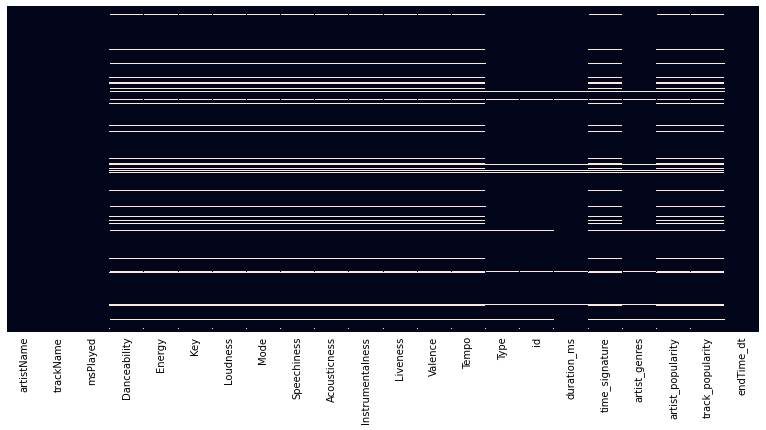

In [8]:
#Visualize missing data
plt.figure(figsize=(12,6))
heat_map = sns.heatmap(df_full_hist_atr.isnull(), cbar=False)
heat_map.set_yticklabels([])
plt.show()

## Reviewing Missing Data and Remove Tracks Without Info
Our first observation is that four columns have no missing data: artistName, trackName, msPlayed, and endtime_dt. This is consistent with our expectations as these are the four columns that comprise our intial listening history dataframe and all came from Spotify. All of the other columns have at least a few null values, which, based on how we searched for and gathered the data, we expected. There are two instances in which null data would be returned based on our search functions. If our search couldn't find the track based on it's name and artist at all then it could not find the trackiD which the rest of the functions were based on. In this instance all fields would be null other than the four recieved from Spotify in the initial dataset. The other case in which null values would appear is for podcasts. Podcasts do not have song or artist attributes, so all attribute fields will return as null for those tracks. <br><br>
We will remove all fields from the dataset that have no additional information beyond what was provided in the original data from spotify, meaning the search function couldn't find the track id. Since these tracks do not have track type information we cannot use them to investigate song vs. podcast listening habits. These tracks make up 384 out of 13035 tracks, or just under 3%. 

In [9]:
#Displaying all tracks that were not found in the search in the data retrieval step
df_full_hist_atr[df_full_hist_atr['id'].isna()][['Type','trackName','artist_genres','Danceability','id']]

,Type,trackName,artist_genres,Danceability,id
105,NaN,FISA Follies & Trump’s Taxes (with Steve Vladeck),NaN,NaN,NaN
185,NaN,Proud (feat. Daecolm) [Dogma Remix],NaN,NaN,NaN
393,NaN,Touch,NaN,NaN,NaN
397,NaN,Touch,NaN,NaN,NaN
408,NaN,Touch,NaN,NaN,NaN
...,...,...,...,...,...
12913,NaN,Evergreen,NaN,NaN,NaN
12965,NaN,Atlantis,NaN,NaN,NaN
12995,NaN,Atlantis,NaN,NaN,NaN
13011,NaN,Let Go,NaN,NaN,NaN


In [10]:
    '''Creating a new dataframe that contains rows from the previous full dataframe with rows with a 
        null value in the 'id' column meaning the search in the data retrieval did not find them'''

clean_full_df = df_full_hist_atr[df_full_hist_atr['id'].notna()].copy()
clean_full_df.head()

,artistName,trackName,msPlayed,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,Valence,Tempo,Type,id,duration_ms,time_signature,artist_genres,artist_popularity,track_popularity,endTime_dt
0,SAINt JHN,Roses - Imanbek Remix,176218,0.769,0.719,8.0,-5.472,1.0,0.0474,0.0143,...,0.863,121.955,track,0zLCBJZSiELJf02ucPP9wb,176867.0,4.0,"['melodic rap', 'rap', 'slap house']",80.0,74.0,2020-04-30 18:01:00
1,Ehrling,In My Soul,1909,0.674,0.801,0.0,-7.340,1.0,0.0399,0.1760,...,0.752,124.104,track,443pVyfo5UEloBAYa91tXf,195484.0,4.0,['tropical house'],65.0,40.0,2020-04-30 18:04:00
2,The Middle Coast,Me Tonight,177426,0.661,0.655,0.0,-7.499,1.0,0.0260,0.0454,...,0.601,113.066,track,2uFCDWBNbw2vKx0Iux69zD,177427.0,4.0,['manitoba indie'],31.0,44.0,2020-04-30 18:04:00
3,Kygo,Like It Is,183067,0.794,0.728,1.0,-6.759,1.0,0.1140,0.1210,...,0.360,105.024,track,3frUvGrmGcay91lvFbOgsN,183067.0,4.0,"['edm', 'pop', 'pop dance', 'tropical house']",87.0,71.0,2020-04-30 18:07:00
4,Tep No,"Breathe, Be Happy - French Braids Remix",171250,0.828,0.729,3.0,-5.198,1.0,0.1300,0.0395,...,0.658,107.994,track,2mCs9yDHgcwbYwGSaT7D7a,171250.0,4.0,"['deep tropical house', 'indie poptimism', 'ne...",62.0,36.0,2020-04-30 18:10:00


## Add Column Converting msPlayed to Minutes Played

In [11]:
#Add column converting msPlayed to minutes played
def ms_to_min(col):
    col_float = float(col)
    return col_float/60000

clean_full_df['Minutes_Played'] = clean_full_df['msPlayed'].apply(ms_to_min)
clean_full_df['Minutes_Played'].head()

0    2.936967
1    0.031817
2    2.957100
3    3.051117
4    2.854167
Name: Minutes_Played, dtype: float64

## Bucket Tracks Based on endTime
We will be analyzing listening tendencies, so we will add some additional columns to bucket songs by the month/year they were listened to in, the day of the week they were listened to, and the time of day they were listened to. 

In [12]:
    '''In order to group songs and podcasts by when they were listened to we'll write functions 
       to extract the month and year, day of the week, and time of day, from the endTime datetime object.'''

def extract_month_year(col): #Function to return year/month from datetime object
        return datetime.strftime(col, '%Y/%m')

def extract_day_of_week(col): #Function to return day of week from datetime object
        return str(datetime.strftime(col, '%w'))

def time_of_day(col): #Function to return time of day from datetime object
        if datetime.strftime(col, '%H.%M') > '00' and datetime.strftime(col, '%H.%M') <= '04':
            return '0-4'
        if datetime.strftime(col, '%H.%M') > '04' and datetime.strftime(col, '%H.%M') <= '08':
            return '4-8'
        if datetime.strftime(col, '%H.%M') > '08' and datetime.strftime(col, '%H.%M') <= '12':
            return '8-12'
        if datetime.strftime(col, '%H.%M') > '12' and datetime.strftime(col, '%H.%M') <= '16':
            return '12-16'
        if datetime.strftime(col, '%H.%M') > '16' and datetime.strftime(col, '%H.%M') <= '20':
            return '16-20'
        if datetime.strftime(col, '%H.%M') > '20' and datetime.strftime(col, '%H.%M') <= '24':
            return '20-24'
    
#Create new columns in the dataframe for the month/year the track was listened to in and the day of the week 
clean_full_df['month_year'] = clean_full_df['endTime_dt'].apply(extract_month_year)
clean_full_df['day_of_week'] = clean_full_df['endTime_dt'].apply(extract_day_of_week)
clean_full_df['Time of Day'] = clean_full_df['endTime_dt'].apply(time_of_day)
clean_full_df.head()

,artistName,trackName,msPlayed,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,duration_ms,time_signature,artist_genres,artist_popularity,track_popularity,endTime_dt,Minutes_Played,month_year,day_of_week,Time of Day
0,SAINt JHN,Roses - Imanbek Remix,176218,0.769,0.719,8.0,-5.472,1.0,0.0474,0.0143,...,176867.0,4.0,"['melodic rap', 'rap', 'slap house']",80.0,74.0,2020-04-30 18:01:00,2.936967,2020/04,4,16-20
1,Ehrling,In My Soul,1909,0.674,0.801,0.0,-7.340,1.0,0.0399,0.1760,...,195484.0,4.0,['tropical house'],65.0,40.0,2020-04-30 18:04:00,0.031817,2020/04,4,16-20
2,The Middle Coast,Me Tonight,177426,0.661,0.655,0.0,-7.499,1.0,0.0260,0.0454,...,177427.0,4.0,['manitoba indie'],31.0,44.0,2020-04-30 18:04:00,2.957100,2020/04,4,16-20
3,Kygo,Like It Is,183067,0.794,0.728,1.0,-6.759,1.0,0.1140,0.1210,...,183067.0,4.0,"['edm', 'pop', 'pop dance', 'tropical house']",87.0,71.0,2020-04-30 18:07:00,3.051117,2020/04,4,16-20
4,Tep No,"Breathe, Be Happy - French Braids Remix",171250,0.828,0.729,3.0,-5.198,1.0,0.1300,0.0395,...,171250.0,4.0,"['deep tropical house', 'indie poptimism', 'ne...",62.0,36.0,2020-04-30 18:10:00,2.854167,2020/04,4,16-20


## Removing Songs and Podcasts from the First and Last Month for Monthly Analysis
My data, after adjusting for timezones, ended up spanning the last day of April 2020 to the first day of May 2021 and only includes seven tracks for each of those months. Since we will be doing some analysis of monthly totals and averages I created a dataframe without the tracks from the first and last month. 

In [13]:
#Checking number of tracks in first and last month. 
print('Number of tracks in first month: ', len(clean_full_df['month_year'].min()))
print('Number of tracks in last month: ', len(clean_full_df['month_year'].max()))

Number of tracks in first month:  7
Number of tracks in last month:  7


In [14]:
    '''Here we are creating a new trimmed data frame without the first and last month of data 
        as those may be shorter months. We're using the month_year column we just created 
        to remove the first and last month. Set trim_first_month and trim_last_month appropriately 
        in settings.py for your data if you want to trim them.'''
if settings.trim_first_month and settings.trim_last_month:
        trimmed_full_df = (clean_full_df[(clean_full_df['month_year'] != clean_full_df['month_year'].min()) 
                        & (clean_full_df['month_year'] != clean_full_df['month_year'].max())].copy())

elif settings.trim_first_month and not settings.trim_last_month:
        trimmed_full_df = clean_full_df[(clean_full_df['month_year'] != clean_full_df['month_year'].min())].copy()
    
elif settings.trim_last_month and not settings.trim_first_month:
        trimmed_full_df = clean_full_df[(clean_full_df['month_year'] != clean_full_df['month_year'].max())].copy()
  
elif not settings.trim_last_month and not settings.trim_first_month:
        trimmed_full_df = clean_full_df.copy()

#Note that even if you do not need to trim your data the df will be called trimmed
trimmed_full_df.head()

,artistName,trackName,msPlayed,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,duration_ms,time_signature,artist_genres,artist_popularity,track_popularity,endTime_dt,Minutes_Played,month_year,day_of_week,Time of Day
21,BRONSON,HEART ATTACK (feat. lau.ra),209600,0.735,0.650,6.0,-5.815,0.0,0.0737,0.1610,...,209600.0,4.0,"['edm', 'vapor twitch']",60.0,66.0,2020-05-01 06:11:00,3.493333,2020/05,5,4-8
22,Lemaitre,Joe,197122,0.656,0.704,11.0,-7.062,1.0,0.0291,0.0381,...,197122.0,4.0,"['alternative dance', 'new french touch', 'nor...",58.0,29.0,2020-05-01 06:14:00,3.285367,2020/05,5,4-8
23,Golden Features,Paradise,215253,0.713,0.703,11.0,-9.452,0.0,0.0501,0.4930,...,215253.0,4.0,[],63.0,57.0,2020-05-01 06:18:00,3.587550,2020/05,5,4-8
24,ODESZA,Memories That You Call (feat. Monsoonsiren) - ...,219506,0.636,0.575,10.0,-4.624,1.0,0.0315,0.0117,...,219507.0,4.0,"['chillwave', 'ninja']",74.0,56.0,2020-05-01 06:22:00,3.658433,2020/05,5,4-8
25,BRONSON,VAULTS,244453,0.652,0.960,9.0,-2.861,0.0,0.0438,0.0360,...,244453.0,4.0,"['edm', 'vapor twitch']",60.0,45.0,2020-05-01 06:26:00,4.074217,2020/05,5,4-8


## Basic Summary Statistics
In the spirit of Spotify's Year in Review, a summary of your years Spotify use, and a service I love, I calculated a few basic summary statistics. 

In [15]:
    '''In the spirit of Spotify's Year in Review, a summary of your years Spotify use, 
    and a service I love, I calculated a few basic summary statistics. '''
    
songs = clean_full_df[clean_full_df['Type'] == 'track'].copy()
podcasts = clean_full_df[clean_full_df['Type'] == 'episode'].copy()
print('Over the last 12 months you listened to:', round(sum(songs['Minutes_Played']),2), 'minutes of music.')
print('Over the last 12 months you listened to:', round(sum(podcasts['Minutes_Played']),2), 'minutes of podcasts.')
print('For a total of:',round(sum(clean_full_df['Minutes_Played']),2), 'minutes of Spotify audio content.')
print('You listened to', songs['artistName'].nunique(), 'unique musical artists on Spotify with an average popularity weighted by plays of',round(songs['artist_popularity'].mean(),2))
print('for a total of', len(songs), 'songs.', songs['trackName'].nunique(), 'of which were unique songs with an average popularity weighted by plays of',round(songs['track_popularity'].mean(),2))
print('Moving on to podcasts you listened to',podcasts['artistName'].nunique(),'different podcasts.')
print('and a total of',len(podcasts),'episodes.')

Over the last 12 months you listened to: 37645.91 minutes of music.
Over the last 12 months you listened to: 20215.41 minutes of podcasts.
For a total of: 57861.31 minutes of Spotify audio content.
You listened to 1350 unique musical artists on Spotify with an average popularity weighted by plays of 61.81
for a total of 11740 songs. 2881 of which were unique songs with an average popularity weighted by plays of 49.29
Moving on to podcasts you listened to 46 different podcasts.
and a total of 911 episodes.


## Analyzing and Visualizing Listening Patterns
Now that we have a clean dataset we can start to investigate our Spotify use over time. We'll investigate whether our listening profile, as characterized by song attributes, is consitent over time or varies. <br>

We'll start by analyzing the correlation of the six song attributes we are investigating over the whole dataframe of songs. This will give us a sense of how these attributes are related to one another on a song to song basis. <br>

We'll then plot the average of each of these attributes on a monthly basis to start to identify how variable our listening tendencies are month to month to see if they are consistent, or if they change over time. <br>

We will then break down listening tendencies of songs vs. podcasts on a monthly, day of week, and time of day basis. 

In [16]:
#Create dataframe of just songs (removing the podcasts) to vizualize song attributes over time
all_song_plays_trim = trimmed_full_df[trimmed_full_df['Type']=='track']
len(all_song_plays_trim)

11703

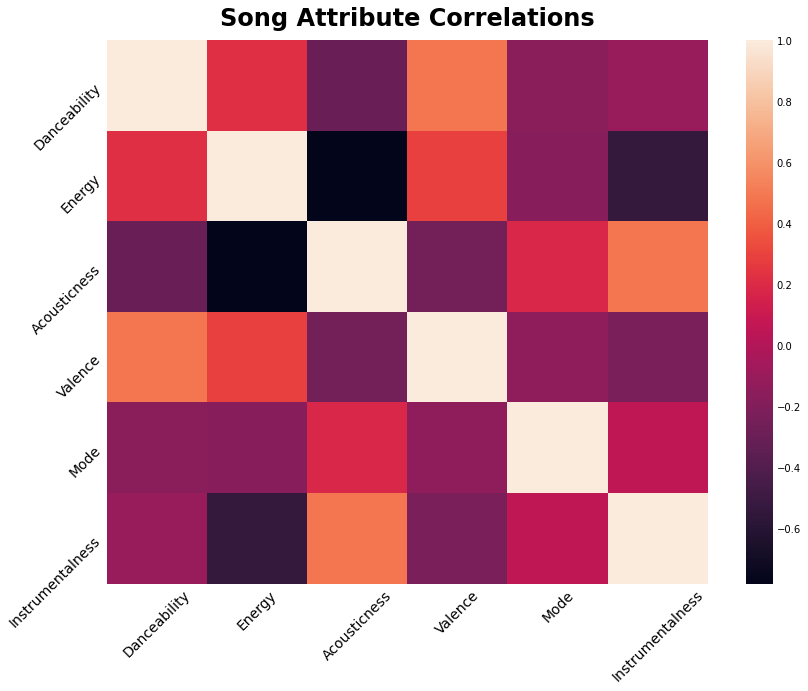

In [17]:
    '''Calculate correlations between all of the attributes we are looking at 
    (Danceability, Energy, Acousticness, Valence, Mode, and Instrumentalness). 
    The list of attributes analyzed can be changed in settings.py'''
all_song_features_corr = all_song_plays_trim[settings.song_attributes].corr()

#Plot the correlations
fig, ax = plt.subplots(figsize=(12,10))
att_heatmap = sns.heatmap(all_song_features_corr)
plt.title("Song Attribute Correlations", fontsize=24, fontweight=750, pad=15)
plt.yticks(rotation = 45, fontsize = 14)
plt.xticks(rotation = 45, fontsize = 14)


plt.show()

## Takeaways from Correlations
While this doesn't tell us anything about listening over time, it will help us understand the connections between these attributes on a song to song basis which will put the over time graphs into context. From these correlations we see strong negative correlations between Energy and Acousticness and between Energy and Instrumentalness. This makes logical sense as we would expect acoustic and instrumental songs to be lower energy. This also aligns with the positive correlation between Acousticness and Instrumentalness. It makes logical sense that acoustic songs would likely be instrumental as well. The last strong correlation we observe is between Valence and Danceability. Valence represents the 'happiness' of a song, so it being positively correlated with danceability makes sense. The rest of the correlations are relatively in the middle between -0.2 and 0.2. <br>

Overall, without additional context the data confirms our existing notion of the give and take within music. Music can cover a wide variety of styles and feelings and as you lean into one you generally take away from another. However, an interesting area of further research would be to collect the data of a large number of people and compare the correlations for the song attributes between them. Perhaps there would be slight differences that could tell us more about the type of music they prefer. Maybe there would be people for whom energy and instrumentalness are positely correlated, telling us they listen to high energy instrumental music, whereas I listen to lower energy instrumental music. <br>

Next, we will visualize the average for each of these attributes on a monthly basis over the course of the year to see if as a music listener I listen to a consistent blend of music or if it ebbs and flows over time. But first we have to take these averages and reorganize the data for vizualization. 

In [18]:
    '''Group the all songs dataframe by the month_year column and take the mean of each attribute for each month. 
        Then sort the values by the month/year'''
month_avg = (all_song_plays_trim[settings.song_attributes + ['month_year']]
             .groupby('month_year').mean().sort_values(by='month_year').reset_index())

month_avg.head(15)

,month_year,Danceability,Energy,Acousticness,Valence,Mode,Instrumentalness
0,2020/05,0.612563,0.574768,0.354938,0.350828,0.558111,0.215613
1,2020/06,0.608133,0.557333,0.375268,0.348248,0.630890,0.250169
2,2020/07,0.612000,0.589650,0.345539,0.374338,0.673624,0.236597
3,2020/08,0.591868,0.386167,0.678051,0.322319,0.784681,0.630007
4,2020/09,0.620324,0.503780,0.454112,0.376932,0.639776,0.332525
5,2020/10,0.645159,0.605070,0.287058,0.451525,0.598485,0.286393
6,2020/11,0.682356,0.501599,0.367322,0.479061,0.452569,0.343944
7,2020/12,0.700402,0.357697,0.444481,0.438808,0.488701,0.563236
8,2021/01,0.613488,0.600421,0.317029,0.385248,0.484919,0.149934
9,2021/02,0.596017,0.575277,0.365103,0.364679,0.552063,0.225618


In [19]:
    '''Melt the data frame on the month_year column. 
    This will leave us with the attribute:average pair for each month/year'''
melt_attribute_avg_month = month_avg.melt(id_vars='month_year')
var_mapper = {'variable':'Variable'}
melt_attribute_avg_month.rename(columns=var_mapper, inplace=True)
melt_attribute_avg_month.head()

,month_year,Variable,value
0,2020/05,Danceability,0.612563
1,2020/06,Danceability,0.608133
2,2020/07,Danceability,0.612000
3,2020/08,Danceability,0.591868
4,2020/09,Danceability,0.620324


## Visualize Song Attributes Over Time
We'll now take our long, melted dataframe from the previous step and graph it as a line chart, with one line for each attribute. 

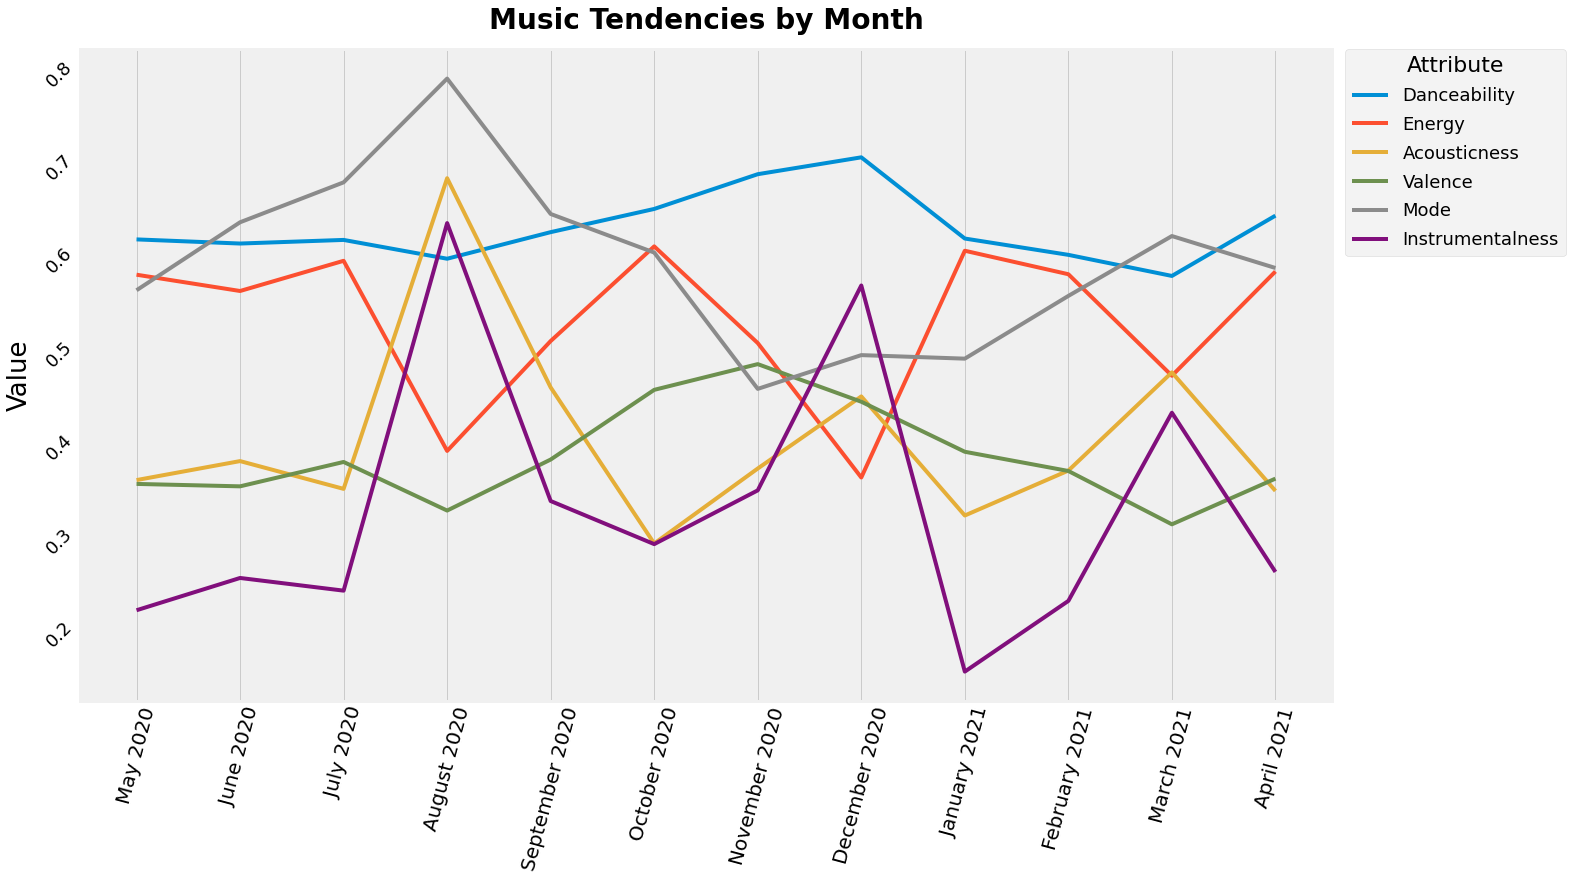

In [20]:
#x-axis labels and locations for months
xlabels = ['May 2020', 'June 2020', 'July 2020', 'August 2020', 'September 2020', 'October 2020', 'November 2020', 'December 2020', 'January 2021', 'February 2021', 'March 2021', 'April 2021']
label_loc = np.arange(len(xlabels))

fig, ax = plt.subplots(figsize=(20, 12)) #Create figure and subplot
sns.lineplot(x='month_year', y='value', hue='Variable', data=melt_attribute_avg_month) #create lineplot
#Plot Title
plt.title("Music Tendencies by Month", fontsize=28, fontweight=750, pad=20)
#Legend settings
plt.setp(ax.get_legend().get_texts(), fontsize='22')
plt.setp(ax.get_legend().get_title(), fontsize='32')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0, fontsize=18, 
           title = 'Attribute', title_fontsize=22, labelspacing=0.6)
#Axis ticks and labels
plt.ylabel('Value', fontsize=26, labelpad=10)
ax.set_xticks(label_loc)
ax.set_xticklabels(labels = xlabels, rotation = 75, fontsize=20)
plt.yticks(rotation = 45, fontsize=18)
plt.grid(b=False, which='both',axis='y')
ax.set(xlabel=None)
#Remove horizontal grid lines
plt.grid(b=False, which='both',axis='y')


plt.show()

## All Attribute Plot Takeaways 
The lineplot with all of the attributes on it is a little bit messy, but a few things stand out to me:<br>
1. The plot confirms the correlations from the correlation maxtrix. When Acousticness and Instrumentalness go up, Energy goes down. Valence follows a roughly similar path to Energy, albeit not as extreme. 
2. Energy and Acousticness/Instrumentalness are fairly all over the place, whereas Danceability and Valence are more consistent. 
3. Mode follows an interesting rise and fall pattern over the course of the year. My existing understanding of the major and minor keys is that major sounds happy and minor sounds sad, but it is not correlated to valence, so further research into the major/minor key and how it is used in music today could be interesting.  <br>

In order to make a more substantive conclusion about my listening habits we need to clear out some of the noise. We'll  split out the attributes that tell a story together. Energy and Acousticness are strongly negatively correlated, so I am interested to see what they look like when plotted together. Danceability and Valence are positively correlated, so I am also interested to take a look at them together. We'll start with Energy and Acousticness. 

## Energy and Acousticness Plot


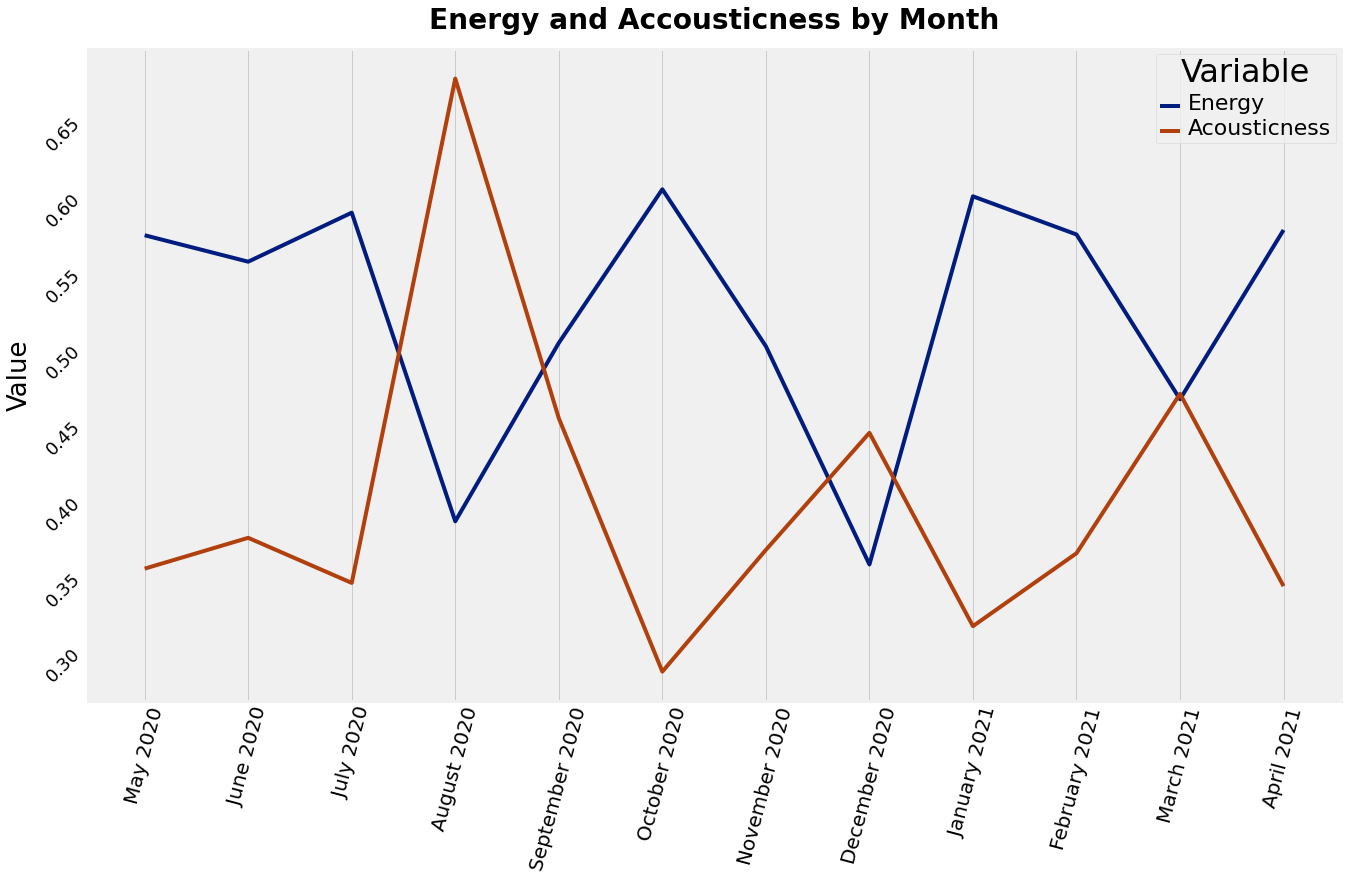

In [21]:
    '''Create a new dataframe with just the rows of the attributes we want to isolate. 
       These variables can be changed in the settings.py file.'''
melt_attribute_trim = melt_attribute_avg_month[melt_attribute_avg_month['Variable'].str.contains(
                        '|'.join(settings.song_attributes_2)).any(level=0)]
#Create figure, axes, and lineplot
fig, ax = plt.subplots(figsize=(20, 12))
sns.lineplot(x='month_year', y='value', hue='Variable', data=melt_attribute_trim, palette = 'dark')
#Plot title
plt.title("Energy and Accousticness by Month", fontsize=28, fontweight=750, pad = 20)
#Legend settings
plt.setp(ax.get_legend().get_texts(), fontsize='22')
plt.setp(ax.get_legend().get_title(), fontsize='32')
#Axis ticks and labels
plt.ylabel('Value', fontsize=26, labelpad=10)
ax.set_xticks(label_loc)
ax.set_xticklabels(labels = xlabels, rotation = 75, fontsize=20)
plt.yticks(rotation = 45, fontsize=18)
plt.grid(b=False, which='both',axis='y')
ax.set(xlabel=None)
#Remove horizontal grid lines
plt.grid(b=False, which='both',axis='y')


plt.show()

## Danceability and Valence Plot

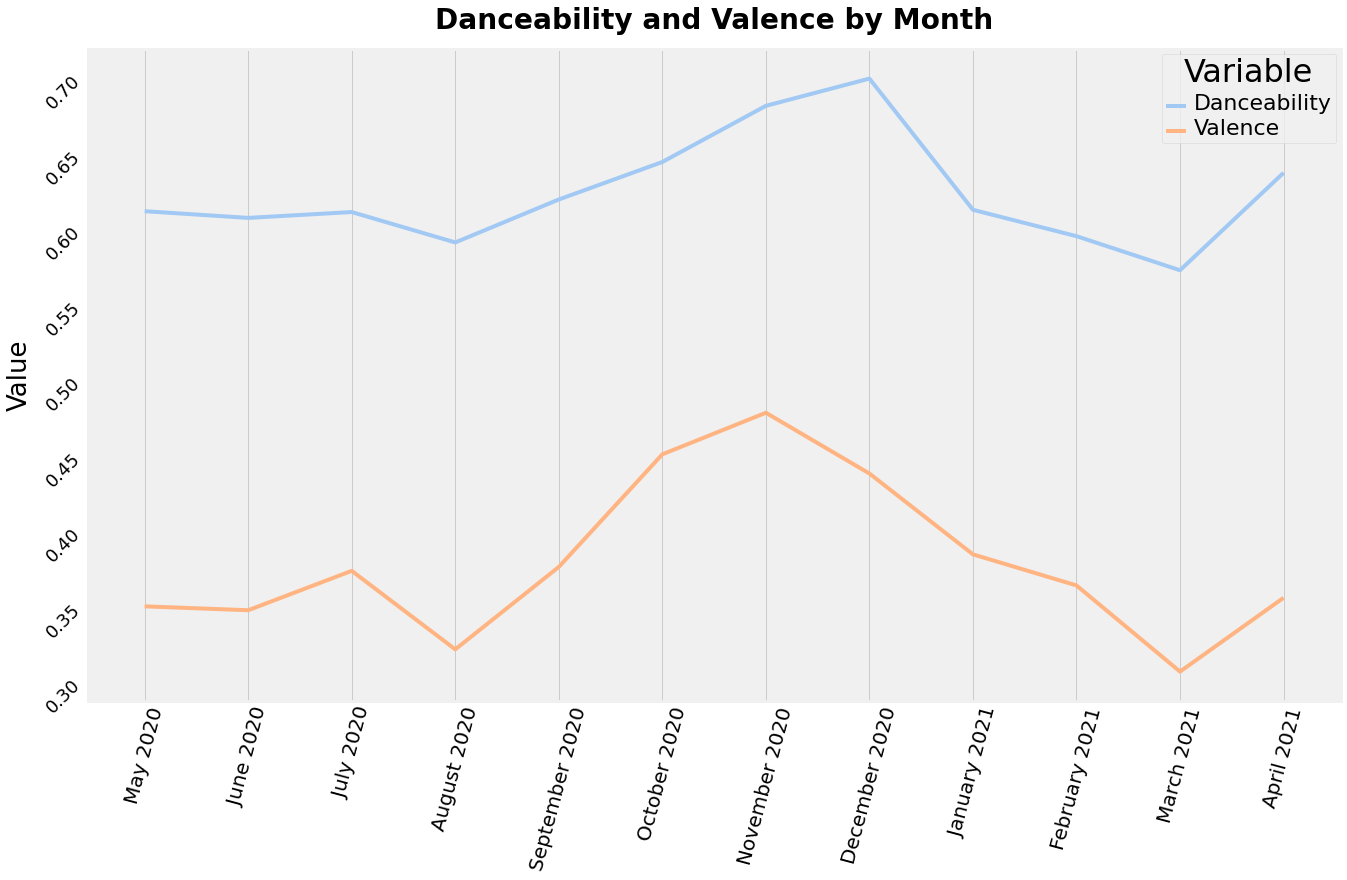

In [22]:
    '''Create a new dataframe with just the rows of the attributes we want to isolate. 
    These variables can be changed in the settings.py file.'''
melt_attribute_trim2 = melt_attribute_avg_month[melt_attribute_avg_month['Variable'].str.contains(
                        '|'.join(settings.song_attributes_3)).any(level=0)]

#Create figure, axes, and lineplot
fig, ax = plt.subplots(figsize=(20, 12))
sns.lineplot(x='month_year', y='value', hue='Variable', data=melt_attribute_trim2, palette = 'pastel')
#Plot title
plt.title("Danceability and Valence by Month", fontsize=28, fontweight=750, pad = 20)
#Legend settings
plt.setp(ax.get_legend().get_texts(), fontsize='22')
plt.setp(ax.get_legend().get_title(), fontsize='32')
#Axis ticks and labels
plt.ylabel('Value', fontsize=26, labelpad=10)
ax.set_xticks(label_loc)
ax.set_xticklabels(labels = xlabels, rotation = 75, fontsize=20)
plt.yticks(rotation = 45, fontsize=18)
plt.grid(b=False, which='both',axis='y')
ax.set(xlabel=None)
#Remove horizontal grid lines
plt.grid(b=False, which='both',axis='y')


plt.show()

## Isolated Attribute Plot Takeaways
What I take away from these graphs is that I, as I am sure most people do, go through phases as a music listener. In my case these phases are clearest when it comes to the energy level of the music. Energy, and it's negative correlary, Acousticness, oscilate wildly month to month. Five out of the Twelve months of the year I switched from the previous month as to whether I was listening to more energetic, or more acoustic music. <br>

When it comes to Danceability and Valence it's a different story. I don't appear to go through quite as radical phases with these features as Danceability remains high throughout the year and Valence remains below 0.50 on average. <br>

I would be curious to see other people's data on these charts to see if, as I suspect, most people go through phases when it comes to their musical tendencies. I would also be curious to know if Spotify takes this pattern into account when recommending me new music. Perhaps they know that after a while of listening to energetic music I have a tendency to switch it up and they adjust my personalized playlists accordingly. Or perhaps adjustments to my personalized playlists (Discover Weekly, Release Radar, etc.), so that I don't feel they get stale, are what are driving this pattern of behavior. 

## When Did I Listen to What? - Songs vs. Podcasts
Next we'll take a look at when we listened to songs vs. playlists and how much of each was listened to. We'll plot the total listening time for each on a monthly basis, on a day of the week basis, and a time of day basis. Creating all three plots follows a similar process to creating the attribute plots except rather than calculating on the attribute columns we calculate on the time column ('Minutes_Played) we created earlier. First up is monthly. 


In [23]:
    '''Group by type and year and sum the minutes played. We'll also change episode to 
       Podcast and track to Song in the type column for clarity.'''
month_count_all = (trimmed_full_df[['Type','month_year', 'Minutes_Played']]
                   .groupby(['Type','month_year']).sum().reset_index().sort_values('month_year'))
month_count_all.loc[month_count_all.Type == 'episode', 'Type'] = 'Podcast'
month_count_all.loc[month_count_all.Type == 'track', 'Type'] = 'Song'
month_count_all.head()

,Type,month_year,Minutes_Played
0,Podcast,2020/05,1048.550383
12,Song,2020/05,2662.121017
1,Podcast,2020/06,956.113000
13,Song,2020/06,3812.092150
2,Podcast,2020/07,888.314750


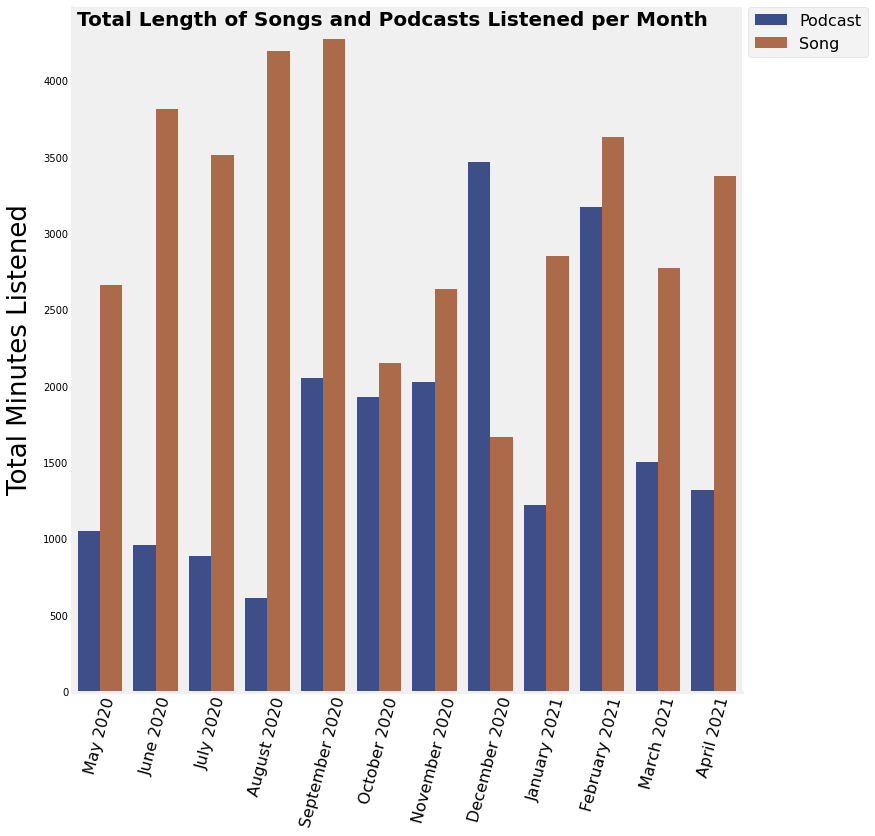

In [24]:
#Create plot in figure - songs and podcasts listened per month
song_podcast = sns.catplot(data = month_count_all, kind='bar',x='month_year', y='Minutes_Played', hue='Type',ci=None, 
                           palette='dark', alpha = .8, height=10, legend=False
                          )
#Plot title
song_podcast.fig.suptitle('Total Length of Songs and Podcasts Listened per Month', fontsize=20, fontweight=750)
#x-axis ticks and labels
ax.set_xticks(label_loc)
song_podcast.set_xticklabels(labels = xlabels, rotation = 75, fontsize=16)
#legend settings
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0, fontsize=16)
plt.ylabel('Total Minutes Listened', fontsize=26, labelpad=10)
#Remove grid lines
plt.grid(b=False, which='both',axis='both')
#Remove x-axis label
song_podcast.set(xlabel=None)



plt.show()

## Takeaways from Monthly Chart
Similar to my music listening habits discussed earlier, I appear to go trough phases when it comes to listening to songs vs. podcasts, although songs are generally higher. From May through September of 2020 I was listening to a lot of songs, but not much on the podcast front. However, from October 2020 through February 2021 my podcast listening trended up. It looks like I'm transitioning back into a song listening phase and my song listening totals are trending up. This confirms my experiences, as I don't feel as though I have been listening to as many podcasts as of late. 

## Visualizing Song vs. Podcast Listening Based on Day of the Week

In [25]:
#This is very similar to by month, just grouping by day_of_week rather than month
dow_count_all = (clean_full_df[['Type','day_of_week', 'Minutes_Played']].groupby(['Type','day_of_week'])
                 .sum().sort_values('day_of_week')).reset_index()
dow_count_all.loc[dow_count_all.Type == 'episode', 'Type'] = 'Podcast'
dow_count_all.loc[dow_count_all.Type == 'track', 'Type'] = 'Song'
dow_count_all.head()

,Type,day_of_week,Minutes_Played
0,Podcast,0,2813.242783
1,Song,0,3188.780283
2,Podcast,1,2293.150617
3,Song,1,4023.816783
4,Podcast,2,3972.477850


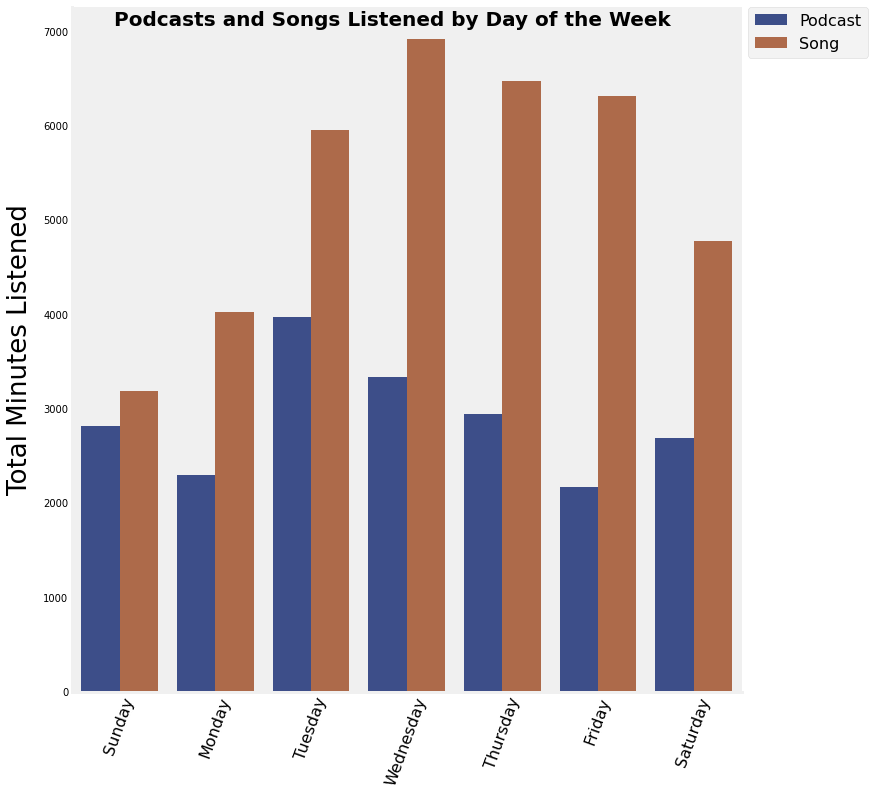

In [26]:
#Day of week tick labels
dow_labels = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

#Create plot in figure
dow_habits = sns.catplot(data = dow_count_all, kind='bar',x='day_of_week', y='Minutes_Played', hue='Type',ci=None, 
                           palette='dark', alpha = .8, height=10, hue_order = ['Podcast','Song'], legend = False
                          )
#Plot title
dow_habits.fig.suptitle('Podcasts and Songs Listened by Day of the Week', fontsize=20, fontweight=750)
#x-axis tick labels and remove axis label
dow_habits.set_xticklabels(dow_labels, rotation = 70, fontsize=16)
dow_habits.set(xlabel=None)
#Legend settings
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0, fontsize=16)
#y-axis label
plt.ylabel('Total Minutes Listened', fontsize=26, labelpad=10)
#Remove grid lines
plt.grid(b=False, which='both',axis='both')
plt.show()

## Takeaways from Day of the Week Listening
This day of the week breakdown shows a consistent peak in song listening towards the end of the week. I think this likely reflects the meeting heavy beginnings of my week at my previous job as I listened to a good amount of music during the day. This takes us into the time of day chart to see if that suspicion is confirmed. 

In [27]:
#Time of day dataframe and plot
tod_count_all = clean_full_df[['Type','Time of Day','Minutes_Played']].groupby(['Type','Time of Day']).sum().sort_values('Time of Day').reset_index()
tod_count_all.loc[tod_count_all.Type == 'episode', 'Type'] = 'Podcast'
tod_count_all.loc[tod_count_all.Type == 'track', 'Type'] = 'Song'
tod_count_all.sort_values('Time of Day', inplace=True)
tod_count_all.head(12)

,Type,Time of Day,Minutes_Played
0,Podcast,0-4,2023.956817
1,Song,0-4,498.328817
2,Podcast,12-16,4561.682533
3,Song,12-16,13326.695000
4,Podcast,16-20,2358.905000
5,Song,16-20,7330.626283
6,Podcast,20-24,4239.337300
7,Song,20-24,2694.415850
8,Podcast,4-8,1011.035383
9,Song,4-8,2162.531767


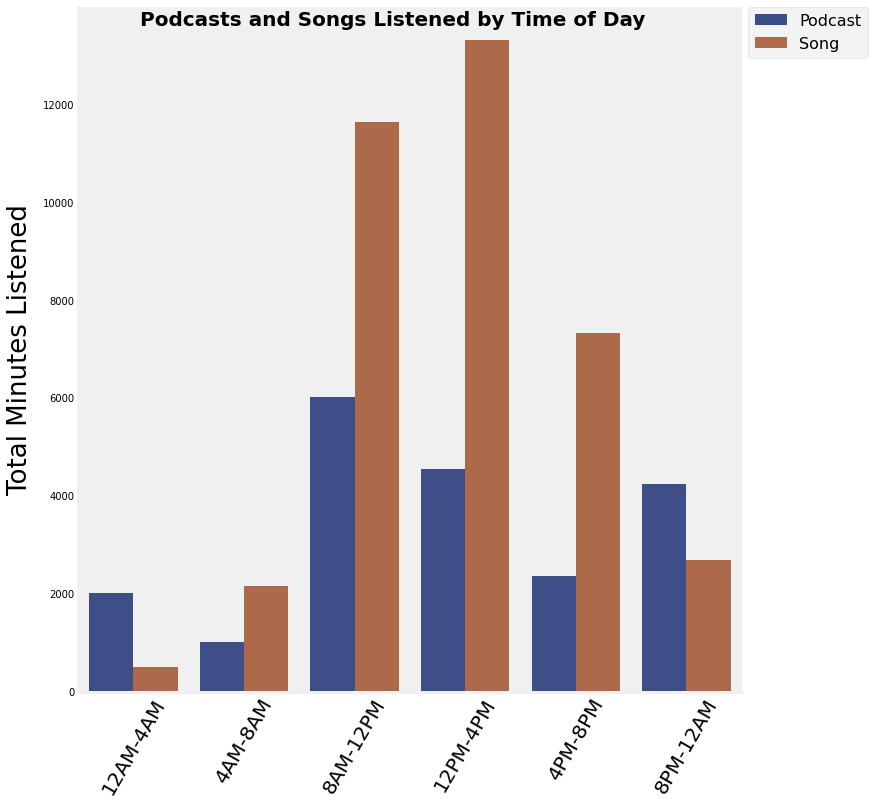

In [28]:
#Column order
column_order = ['0-4','4-8','8-12','12-16','16-20','20-24']
#Time of day x axis tick labels
tod_x_labels = ['12AM-4AM', '4AM-8AM', '8AM-12PM','12PM-4PM','4PM-8PM','8PM-12AM']
#x tick axis locations
tod_label_loc = np.arange(len(tod_x_labels))

tod_habits = sns.catplot(data = tod_count_all, kind='bar',x='Time of Day', y='Minutes_Played', hue='Type',ci=None, 
                           palette='dark', alpha = .8, height=10, hue_order = ['Podcast','Song'], order=column_order,
                         legend = False
                          )
#Remove grid lines
plt.grid(b=False, which='both',axis='both')
#Plot title
tod_habits.fig.suptitle('Podcasts and Songs Listened by Time of Day', fontsize=20, fontweight=750)
#x-axis tick settings
ax.set_xticks(tod_label_loc)
tod_habits.set_xticklabels(labels = tod_x_labels, rotation = 60, fontsize=20)
tod_habits.set(xlabel=None)
#legend settings
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0, fontsize=16)
#y-axis label
plt.ylabel('Total Minutes Listened', fontsize=26, labelpad=10)
plt.show()

## Time of Day Plot Takeaways
This chart confirms my suspicion that a meeting heavy beginning to the week would lead to less consumption of music as I do most of my listening to music during the day. I think it is interesting to see that I listen to more podcasts at night. I tend to listen to podcasts while I'm preparing for bed, so that makes sense to me based on my experience. 

## So, Who am I (as a Spotify Listener)? 
While maybe not as weighted of a question as Who am I, an important one none the less. By looking at the average song attributes of the music I listened to over time I conclude that I have somewhat eratic listening patterns and go through phases of listening to higher and lower energy music. What triggers these changes is unknown. Whether it be boredom with what I'm currently listening to, or perhaps a change in the songs being recommended to me I cannot be sure. I would also guess that what is going on at work or in my life has a large impact on the type of music I am listening to. When I am busy at work I tend to listen to quieter, more laid back music to allow me to focus. This could certainly be a factor at play, although at the present moment I do not have the data to investigate. <br><br>
I noticed a similar trend in my behavior when it comes to listening to songs and podcasts. Rather than listening to a consistent balance of the two accross time, I go through phases with heavier listening one way or the other. I have a tendency to get very involved in subjects and want to immerse myself in them, so I would guess that at these times my podcast listening goes up as I starting listening to new podcasts on whatever subject I might be trying to learn about. Over time my intererst in the subject may wane and I either move onto something new or revert back to heavy music listening. I think this element of my personality is reflected in my listening patterns. Looking at the days of the week my primary takeaway is that when I am engaged in meetings I am, of course, not listening to music, but when I have more time and am working independently I listen to music as I work. Lastly, supporting that point, I do most of my music and podcast listening during the day, with an uptake in podcast intake prior to bed. <br>


<b>Possible Further Work</b><br>
1. Whether these types of patterns are typical, or if other people are more consistent in their patterns over time.
2. Compare attribute correlations between people to see if the correlations in my listening history hold up on a larger scale.
3. How my listening history attribute profile compares to popular playlists.
4. Compare volume of songs to their attributes. As the amount listened to goes up, do certain song attributes go up or down with it?
5. Repeating this analysis with a longer time frame. One year, particularily this strange year, is not totally representive of an individuals overall tendencies. 
6. Run a regression analysis to see if any variation in number of plays wer song can be explained by the song attributes.